In [1]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

#data processing
import re, string
import nltk
import sklearn
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel
from transformers import RobertaModel, RobertaTokenizer

import torch
from torch.utils.data import DataLoader, Dataset

#sdv
from sdv.evaluation import evaluate
from sdv.metrics.tabular import CSTest, KSTest, LogisticDetection, SVCDetection
from sdv.tabular import CTGAN, TVAE, CopulaGAN, GaussianCopula

#keras
import tensorflow as tf
from tensorflow import keras

#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

2023-06-03 23:03:34.197537: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/martagracia/Library/Python/3.9/lib/python/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/martagracia/Library/Python/3.9/lib/python/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to 

In [2]:
import warnings
warnings.filterwarnings('ignore')

import joblib
import re
import string

from nltk.corpus import stopwords
from datetime import datetime
from apyori import apriori
import lxml.etree as ET
import pandas as pd
import numpy as np
import unidecode
import html
import os
import re

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.naive_bayes import MultinomialNB

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Define paths

In [3]:
NEWS_PATH = '../data/news/'

# Create data

In [4]:
def normalize_string(to_normalize, encoded = False, remove_stopwords = True):
    '''
    Normalize text given a string
    '''
    text = str(to_normalize).lower()  # lowering text
    if encoded: 
        text = ' '.join([html.unescape(term) for term in text.split()])
    text = unidecode.unidecode(text)

    text = re.sub(r'[^\w\s]', '', text)  # removing all the punctuations
    last_text = text.split()  # tokenize the text

    # remove stopwords
    stopwords_set = set()
    if remove_stopwords: stopwords_set = set(stopwords.words("spanish"))
    
    last_text = ' '.join([x for x in last_text if (x not in stopwords_set)])
    return last_text

def listdir_checked(path, unwanted = ['.DS_Store']):
    '''
    Discard unwanted files or directories when listing the elements in a given path
    '''
    return (f for f in os.listdir(path) if f not in unwanted)


def create_articles_dictionary(NEWS_PATH):
    '''
    Import articles information.
    Articles are stored in directories in the NEWS_PATH.
    '''
    data = {}               # keys: media, value: list of dictionaries with info about the news articles of the given media
    unique_urls = []        # list to store unique urls to discard repeated ones
    repeated_data = {}      # store repeated articles following the same format as 'data' dictionary

    for year in listdir_checked(NEWS_PATH):
        for month in listdir_checked(NEWS_PATH + '/' + year):
            for file in listdir_checked(NEWS_PATH + '/' + year + '/' + month):
                try:
                    full_path = NEWS_PATH + '/' + year + '/' + month + '/' + file
                    # Read xml file - info stored following NewsML-G2 format
                    root = ET.parse(full_path).getroot()
                    # Parse news
                    media = file.rsplit('_', 1)[0]
                    # Check repeated urls
                    url = root.findall(".//infoSource")[0].get("uri")
                    str_date = root.findall('.//contentMeta')[0].find('contentCreated').text[:10]
                    info = {
                        'id': file.split(':')[-1].replace('.xml', ''),
                        'media': media,
                        'publication_date': datetime.strptime(str_date, '%Y-%m-%d'),
                        'title': normalize_string(root.findall('.//itemRef')[0].find('title').text, encoded = True, remove_stopwords = False),
                        'headline': normalize_string(root.findall(".//itemRef")[0].find('description').text.strip(), encoded = True, remove_stopwords = False),
                        'article': normalize_string(root.findall('.//itemRef')[1].find('description').text.strip(), encoded = True, remove_stopwords = False),
                        'url': url
                    }

                    if url not in unique_urls:
                        unique_urls.append(url)
                        try:
                            data[media].append(info)
                        except:
                            data[media] = [info]

                    else:
                        try:
                            repeated_data[media].append(info)
                        except:
                            repeated_data[media] = [info]
                except:
                    pass
                    
    return data, repeated_data


def get_data_info(data, dict_key, value):
    '''
    Aux function to obtain the info of the articles with the given 
    value for the provided dict_key in data
    '''
    matching_elements = []
    for media, news in data.items():
        for article in news:
            if article[dict_key] == value:
                matching_elements.append(article)
    return matching_elements

In [5]:
data, repeated_data = create_articles_dictionary(NEWS_PATH)

articles_list = []

for media in data.keys():
    for new in data[media]:
        tweet_id = new['id']
        title = normalize_string(new['title'])
        headline = normalize_string(new['headline'])
        url = new['url']
        publication_date = new['publication_date']
        article = normalize_string(new['article'])
        
        articles_list.append({'tweet_id': tweet_id, 
                              'media': media, 
                              'title': title, 
                              'headline': headline, 
                              'url': url, 
                              'article': article,
                              'publication_date': publication_date})

articles_df = pd.DataFrame(articles_list)

articles_df['tweet_id'] = articles_df['tweet_id'].str.split('_').str[-1]
articles_df['media'] = articles_df['media'].str.split('_').str[0]
articles_df['tweet_id'] = articles_df['tweet_id'].astype(int)

#RENAME SOME MEDIA
articles_df['media'] = articles_df['media'].replace({'La': 'LaSER', 
                                                     'el': 'elPais',
                                                     'noticias': 'noticiascuatro',
                                                     'publico': 'diarioPublico',
                                                     'voz': 'vozpopuli'});

In [6]:
articles_df['text'] = articles_df['title'] + ' ' + articles_df['headline'] + ' ' + articles_df['article']

In [7]:
articles_df.head()

,tweet_id,media,title,headline,url,article,publication_date,text
0,1212203735650328577,20m,name britanica detenida falso testimonio tras ...,name joven britanica 19 anos mes julio detenida,https://www.20minutos.es/noticia/4102525/0/cul...,name joven britanica 19 anos mes julio detenid...,2019-12-31,name britanica detenida falso testimonio tras ...
1,1212467642428280832,20m,name parto nina 13 anos violada padre,name name nina brasilena 13 anos fallecio comi...,https://www.20minutos.es/noticia/4103250/0/mue...,name name nina brasilena 13 anos fallecio comi...,2020-01-01,name parto nina 13 anos violada padre name nam...
2,1212826760234127360,20m,name 3 jovenes acusados violar 3 hermanas esta...,name name name detenido jueves tres jovenes ac...,https://www.20minutos.es/noticia/4104199/0/det...,name name name detenido jueves tres jovenes ac...,2020-01-02,name 3 jovenes acusados violar 3 hermanas esta...
3,1213232973715267584,20m,name claves name juicio name name abusos sexua...,name juicio supuestos abusos sexuales todopode...,https://www.20minutos.es/noticia/4105188/0/cla...,name juicio supuestos abusos sexuales todopode...,2020-01-03,name claves name juicio name name abusos sexua...
4,1213348259076415488,20m,name name name investiga escritor frances name...,name name name abierto viernes investigacion e...,https://www.20minutos.es/noticia/4104916/0/fra...,name name name abierto viernes investigacion e...,2020-01-03,name name name investiga escritor frances name...


# NUM. AGRESORES

In [8]:
label_df = pd.read_csv('manual_labeling_3.csv')
label_df = label_df.drop_duplicates(subset=['ID'])
label_df['ID'] = label_df['ID'].astype(str)
articles_df['tweet_id'] = articles_df['tweet_id'].astype(str)
# Concatenar los DataFrames basados en las columnas 'tweet_id' y 'ID'
train_label_df = pd.concat([articles_df.set_index('tweet_id'), label_df.set_index('ID')], axis=1, join='inner').reset_index()
train_label_df.rename(columns={'index': 'tweet_id'}, inplace=True)

train_label_df.head()

,tweet_id,media,title,headline,url,article,publication_date,text,CONOCIDO,PAREJA/EX,FAMILIAR,NUM. AGR
0,1212203735650328577,20m,name britanica detenida falso testimonio tras ...,name joven britanica 19 anos mes julio detenida,https://www.20minutos.es/noticia/4102525/0/cul...,name joven britanica 19 anos mes julio detenid...,2019-12-31,name britanica detenida falso testimonio tras ...,0,0,0,1
1,1212467642428280832,20m,name parto nina 13 anos violada padre,name name nina brasilena 13 anos fallecio comi...,https://www.20minutos.es/noticia/4103250/0/mue...,name name nina brasilena 13 anos fallecio comi...,2020-01-01,name parto nina 13 anos violada padre name nam...,1,0,1,0
2,1212826760234127360,20m,name 3 jovenes acusados violar 3 hermanas esta...,name name name detenido jueves tres jovenes ac...,https://www.20minutos.es/noticia/4104199/0/det...,name name name detenido jueves tres jovenes ac...,2020-01-02,name 3 jovenes acusados violar 3 hermanas esta...,0,0,0,1
3,1213232973715267584,20m,name claves name juicio name name abusos sexua...,name juicio supuestos abusos sexuales todopode...,https://www.20minutos.es/noticia/4105188/0/cla...,name juicio supuestos abusos sexuales todopode...,2020-01-03,name claves name juicio name name abusos sexua...,1,0,0,2
4,1213348259076415488,20m,name name name investiga escritor frances name...,name name name abierto viernes investigacion e...,https://www.20minutos.es/noticia/4104916/0/fra...,name name name abierto viernes investigacion e...,2020-01-03,name name name investiga escritor frances name...,0,0,0,0


In [60]:
train_label_df['NUM. AGR'].value_counts()

0    539
1    219
2    126
Name: NUM. AGR, dtype: int64

In [9]:
agr_train, agr_test = train_test_split(train_label_df, test_size=0.2, random_state=seed)

In [10]:
# train
X_train = agr_train['text']
y_train = agr_train['NUM. AGR']
agr_train = agr_train[['text', 'NUM. AGR']]

# test
X_test = agr_test['text']
y_test = agr_test['NUM. AGR']
agr_test = agr_test[['text', 'NUM. AGR']]

In [11]:
agr_train.reset_index(drop=True, inplace=True)
agr_test.reset_index(drop=True, inplace=True)

In [12]:
agr_train['NUM. AGR'].value_counts()

0    430
1    182
2     95
Name: NUM. AGR, dtype: int64

# Labeled

IMPORT ARTICLES LABELED MANUALLY

### Synthetic Data Generation: TVAE and CTGAN Models

In [17]:
model_tvae = TVAE()
model_ctgan = CTGAN()

In [18]:
model_tvae.fit(agr_train)
new_data_tvae = model_tvae.sample(agr_train.shape[0])
new_data_tvae.head()

,text,NUM. AGR
0,name dos menores posible violacion grupal meno...,1
1,name seleccion femenina name denuncia abusos n...,0
2,name hombre ofrecia 100 euros menores cambio f...,0
3,name presunto autor agresion sexual joven name...,0
4,juicio colgar name video pareja manteniendo re...,0


In [19]:
model_ctgan.fit(agr_train)
new_data_ctgan = model_ctgan.sample(agr_train.shape[0])
new_data_ctgan.head()

,text,NUM. AGR
0,name internos name dan paliza preso asesinar n...,0
1,name mujer name nieta carreras caballos name n...,1
2,prision detenidos name presunta agresion sexua...,0
3,name tres personas name explotar sexualmente m...,0
4,name gobierno socialista name sigue guardando ...,0


In [20]:
new_data_ctgan['NUM. AGR'].value_counts()

0    416
2    180
1    111
Name: NUM. AGR, dtype: int64

Evaluation of the model

In [21]:
metrics = ["CSTest", "KSTest"]

In [22]:
evaluate(
    new_data_tvae,
    agr_train,
)

0.662000114132077

In [23]:
evaluate(
    new_data_ctgan,
    agr_train
)

0.9547554374508884

In [24]:
new_data_ctgan.to_csv('synthetic_data_ctgan_agr.csv')

ctgan modelos mas de tablas, modelo tvae mas de texto libre

### Juntamos datos reales y sinteticos

In [25]:
data_train_all = pd.concat([agr_train, new_data_ctgan], ignore_index=True)

In [26]:
X_train = data_train_all['text']
y_train = data_train_all['NUM. AGR']

In [27]:
y_train.value_counts()

0    846
1    293
2    275
Name: NUM. AGR, dtype: int64

We note that the three classes are imbalanced. We will proceed with oversampling the train test, to remove bias towards the majority classes.

Tenemos los datos super unbalanced, aplicaremos oversampling

"Si el rendimiento y la capacidad de detección de la clase minoritaria son importantes, puede ser recomendable utilizar oversampling para generar más instancias sintéticas de la clase minoritaria y equilibrar la distribución de clases. Esto permitiría al modelo aprender y capturar mejor las características de la clase minoritaria."

In [28]:
# Aplicar undersampling en la clase mayoritaria (clase 0)
rus = RandomUnderSampler(sampling_strategy={0: 600})
undersampled_x, undersampled_y = rus.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1))

# Aplicar oversampling en las clases minoritarias (clases 1, 2 y 3)
ros = RandomOverSampler(sampling_strategy={2: 400, 1: 400})
oversampled_x, oversampled_y = ros.fit_resample(np.array(undersampled_x).reshape(-1, 1), np.array(undersampled_y).reshape(-1, 1))
train_data = pd.DataFrame(list(zip([x[0] for x in oversampled_x], oversampled_y)), columns=['text', 'NUM. AGR'])

In [29]:
train_data['NUM. AGR'].value_counts()

0    600
1    400
2    400
Name: NUM. AGR, dtype: int64

In [30]:
train_data.head()

,text,NUM. AGR
0,name 27 anos prision hombre sometida 40 dias m...,0
1,name abusos sexuales menores empezaran prescri...,0
2,name name abusar name dejar embarazada nieta p...,0
3,hombre apunala pareja name name entrega volunt...,0
4,name anciano dos anos carcel abusar sexualment...,0


One hot encoding in Train, Val and Test

In [31]:
ohe = preprocessing.OneHotEncoder()
y_train_ohe = ohe.fit_transform(np.array(train_data['NUM. AGR']).reshape(-1, 1)).toarray()
y_test_ohe = ohe.fit_transform(np.array(agr_test['NUM. AGR']).reshape(-1, 1)).toarray()

# tokenizer

First, we import the BERT tokenizer.

In [32]:
tokenizer = BertTokenizerFast.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

In [33]:
token_lens = []

for txt in train_data['text'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)

In [34]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 512


In [35]:
train_data['token_lens'] = token_lens

In [36]:
train_data['token_lens'].value_counts()

512    208
249     16
182     14
202     14
442     14
250     13
367     12
464     12
321     12
227     12
262     11
275     11
201     11
270     10
259     10
273     10
204     10
288      9
456      9
159      9
167      9
212      9
166      9
144      9
208      9
416      8
152      8
319      8
492      8
345      8
206      8
256      8
328      8
194      8
219      8
123      8
408      7
350      7
138      7
196      7
170      7
248      7
303      7
329      7
378      7
165      7
180      7
358      7
244      7
384      7
284      7
265      7
336      7
334      7
157      7
348      7
175      7
122      7
252      6
155      6
361      6
370      6
69       6
68       6
230      6
210      6
209      6
120      6
505      6
298      6
147      6
296      6
187      5
349      5
424      5
422      5
389      5
198      5
281      5
246      5
277      5
253      5
362      5
139      5
186      5
171      5
325      5
278      5
451      5
131      5
450      5

EN LOS ARTICULOS LA INFORMACIÓN MÁS RELEVANTE SIEMPLE ESTA EN EL TITULO, EN EL HEADLINE O AL INICIO DEL ARTICULO EN SI, POR ESO CONSIDERAMOS LA OPCIÓN DE TOKENIZAR POR UN MAXIMO DE 512 Y TODO LO OTRO HACER TRUNCACION Y ELIMINARLO

In [37]:
MAX_LEN = 250

In [38]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            truncation=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [39]:
train_data.reset_index(drop=True, inplace=True)
agr_test.reset_index(drop=True, inplace=True)

In [40]:
train_input_ids, train_attention_masks = tokenize(train_data['text'], MAX_LEN)
test_input_ids, test_attention_masks = tokenize(agr_test['text'], MAX_LEN)

# BERT Modeling

In [41]:
bert_model = TFBertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
def create_model(bert_model, max_len=MAX_LEN):
    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    embeddings = bert_model([input_ids,attention_masks])[1]
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    
    return model

In [43]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109850880   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 250,                                           

In [44]:
model.fit([train_input_ids,train_attention_masks], y_train_ohe, epochs=4, batch_size=16)  

Epoch 1/4
88/88 [==============================] - 4490s 51s/step - loss: 1.0886 - categorical_accuracy: 0.4257
Epoch 2/4
88/88 [==============================] - 4477s 51s/step - loss: 0.9623 - categorical_accuracy: 0.5614
Epoch 3/4
88/88 [==============================] - 4522s 51s/step - loss: 0.9034 - categorical_accuracy: 0.5836
Epoch 4/4
88/88 [==============================] - 4508s 51s/step - loss: 0.8255 - categorical_accuracy: 0.6429


In [45]:
result_bert = model.predict([test_input_ids,test_attention_masks])

6/6 [==============================] - 132s 21s/step


In [46]:
y_pred_bert = np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1
result_berttt = pd.DataFrame(result_bert)
result_berttt.to_csv('result_bert_arg.csv')
y_pred_bertberttt = pd.DataFrame(y_pred_bert)
y_pred_bertberttt.to_csv('y_pred_bert_arg.csv')

### BERT Results

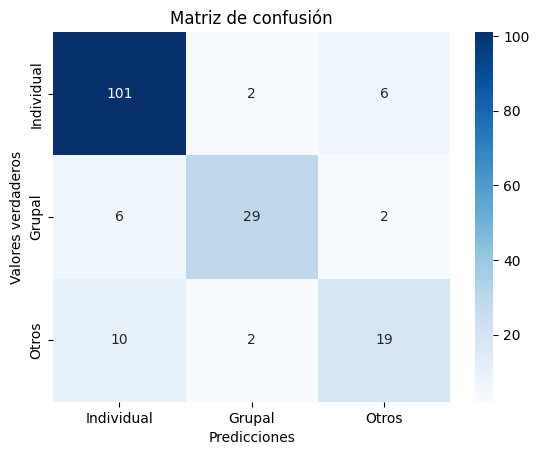

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Obtén la matriz de confusión
cm = confusion_matrix(y_test_ohe.argmax(axis=1), y_pred_bert.argmax(axis=1))

# Define las etiquetas de las clases
labels = ['Individual', 'Grupal', 'Otros']

# Crea el mapa de calor utilizando seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)

# Configura las etiquetas de los ejes y el título
plt.xlabel('Predicciones')
plt.ylabel('Valores verdaderos')
plt.title('Matriz de confusión')

# Muestra el mapa de calor
plt.show()


In [63]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test_ohe,y_pred_bert, target_names=['Individual', 'Grupal', 'Otros']))

	Classification Report for BERT:

               precision    recall  f1-score   support

  Individual       0.86      0.93      0.89       109
      Grupal       0.88      0.78      0.83        37
       Otros       0.70      0.61      0.66        31

   micro avg       0.84      0.84      0.84       177
   macro avg       0.82      0.77      0.79       177
weighted avg       0.84      0.84      0.84       177
 samples avg       0.84      0.84      0.84       177



Con base en la matriz de confusión y el informe de clasificación proporcionados, podemos obtener las siguientes conclusiones:

1. Precisión (Precision): La precisión de la clase 0 (Class 0) es del 81%, lo que significa que el 81% de las muestras clasificadas como clase 0 son realmente de esa clase. La precisión de las clases 1 (Class 1), 2 (Class 2) y 3 (Class 3) es del 73%, 100% y 80% respectivamente.

2. Sensibilidad o Tasa de Verdaderos Positivos (Recall o True Positive Rate): La sensibilidad de la clase 0 es del 93%, lo que indica que el 93% de las muestras verdaderamente pertenecientes a la clase 0 se clasificaron correctamente. La sensibilidad de las clases 1, 2 y 3 es del 80%, 77% y 57% respectivamente.

3. Valor F1 (F1-Score): El valor F1 de la clase 0 es del 86%, lo que combina la precisión y la sensibilidad en una medida única. Los valores F1 de las clases 1, 2 y 3 son del 76%, 87% y 67% respectivamente.

4. Exactitud (Accuracy): La exactitud general del modelo es del 84%, lo que indica que el 84% de las muestras se clasificaron correctamente en general.

5. La matriz de confusión muestra la distribución de las clasificaciones correctas e incorrectas en cada clase. Por ejemplo, la clase 0 tiene 38 muestras clasificadas correctamente, 2 muestras clasificadas incorrectamente como clase 1, 0 muestras clasificadas incorrectamente como clase 2 y 1 muestra clasificada incorrectamente como clase 3.

En resumen, se puede concluir que el modelo BERT tiene un rendimiento razonablemente bueno, con altas precisiones y sensibilidades en la mayoría de las clases. Sin embargo, la clase 3 muestra una sensibilidad más baja, lo que indica que el modelo tiene dificultades para detectar correctamente las muestras de esa clase. Esto se refuerza por el valor F1 más bajo de la clase 3 en comparación con las otras clases. Es importante evaluar el rendimiento del modelo en función de los objetivos y requisitos específicos del problema en cuestión.

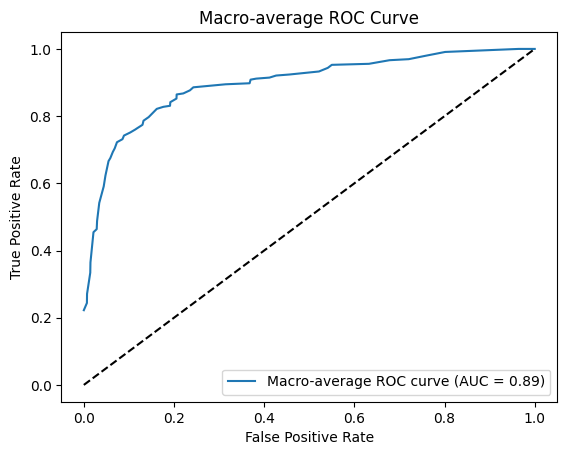

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def macro_roc_curve(y_true, y_scores):
    # Calcula la curva ROC y el área bajo la curva (AUC) para cada clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_scores.shape[1]

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcula el promedio de los valores de TPR y FPR
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    # Calcula el promedio del AUC
    mean_auc = np.mean(list(roc_auc.values()))

    # Construye la curva ROC con los valores promediados
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = mean_auc

    return fpr, tpr, roc_auc

# Ejemplo de uso
# y_true: etiquetas verdaderas de forma (n_samples, n_classes)
# y_scores: probabilidades de predicción de forma (n_samples, n_classes)
y_true = y_test_ohe
y_scores = result_bert
fpr, tpr, roc_auc = macro_roc_curve(y_true, y_scores)

# Visualiza la curva ROC promediada
plt.figure()
plt.plot(fpr["macro"], tpr["macro"], label='Macro-average ROC curve (AUC = {:.2f})'.format(roc_auc["macro"]))
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [50]:
def plot_roc_curves(y_true, y_scores):
    # Calcula la curva ROC y el área bajo la curva (AUC) para cada clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_scores.shape[1]

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        # Construye y muestra la curva ROC para la clase i
        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {} (AUC = {:.2f})'.format(i, roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Class {}'.format(i))
        plt.legend(loc='lower right')
        plt.show()

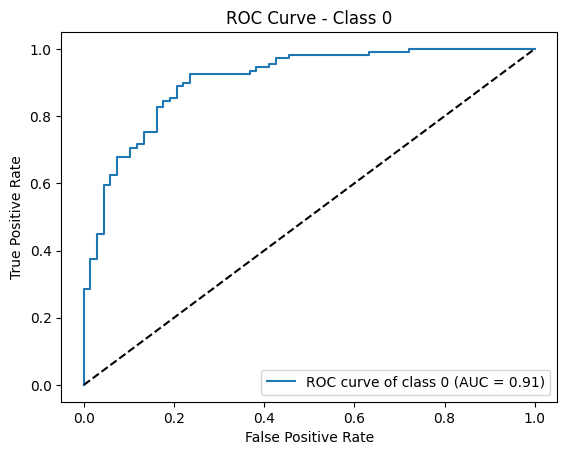

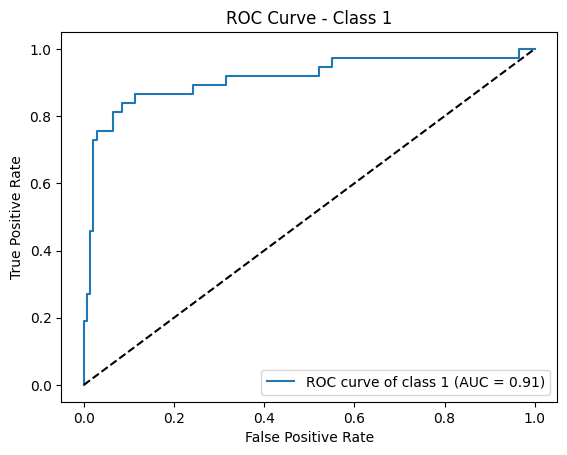

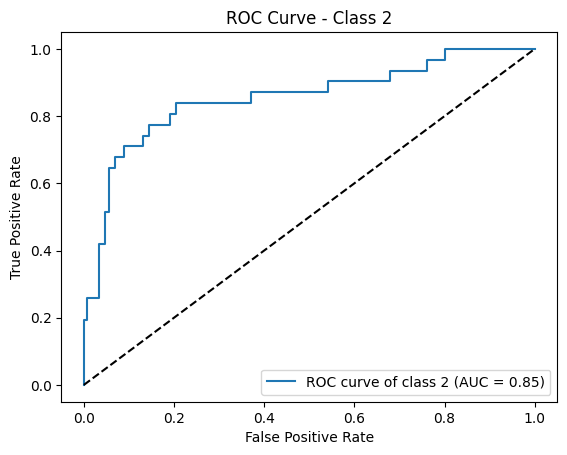

In [51]:
y_true = y_test_ohe
y_scores = result_bert
plot_roc_curves(y_true, y_scores)

# Predict label all articles

In [54]:
# Preprocess unlabeled data
articles_input_ids, articles_attention_masks = tokenize(articles_df['text'], MAX_LEN)

# Predict labels for unlabeled data
articles_predictions = model.predict([articles_input_ids, articles_attention_masks])

468/468 [==============================] - 9908s 21s/step


In [56]:
#np.save('articles_predictions_agr', articles_predictions)

In [57]:
#articles_predictions = np.load('articles_predictions_agr.npy')

In [55]:
articles_predictions

array([[0.5353212 , 0.2148723 , 0.24980648],
       [0.9057288 , 0.04032118, 0.05394997],
       [0.35763916, 0.5651102 , 0.07725059],
       ...,
       [0.74869007, 0.0892756 , 0.1620342 ],
       [0.73575836, 0.11051025, 0.15373126],
       [0.7337715 , 0.15760326, 0.10862517]], dtype=float32)

In [64]:
articles_pred_df = pd.DataFrame(articles_predictions)
articles_pred_df = articles_pred_df.rename(columns={0: 'prob_individual', 1: 'prob_grupal', 2: 'prob_otros'})
articles_pred_df['label_predict'] = np.argmax(articles_pred_df.values, axis=1)
articles_pred_df.head()

,prob_individual,prob_grupal,prob_otros,label_predict
0,0.535321,0.214872,0.249806,0
1,0.905729,0.040321,0.053950,0
2,0.357639,0.565110,0.077251,1
3,0.236147,0.033098,0.730755,2
4,0.864866,0.066744,0.068390,0


In [66]:
concatenated_df = pd.concat([articles_df, articles_pred_df], axis=1)
concatenated_df.head()

,tweet_id,media,title,headline,url,article,publication_date,text,prob_individual,prob_grupal,prob_otros,label_predict
0,1212203735650328577,20m,name britanica detenida falso testimonio tras ...,name joven britanica 19 anos mes julio detenida,https://www.20minutos.es/noticia/4102525/0/cul...,name joven britanica 19 anos mes julio detenid...,2019-12-31,name britanica detenida falso testimonio tras ...,0.535321,0.214872,0.249806,0
1,1212467642428280832,20m,name parto nina 13 anos violada padre,name name nina brasilena 13 anos fallecio comi...,https://www.20minutos.es/noticia/4103250/0/mue...,name name nina brasilena 13 anos fallecio comi...,2020-01-01,name parto nina 13 anos violada padre name nam...,0.905729,0.040321,0.053950,0
2,1212826760234127360,20m,name 3 jovenes acusados violar 3 hermanas esta...,name name name detenido jueves tres jovenes ac...,https://www.20minutos.es/noticia/4104199/0/det...,name name name detenido jueves tres jovenes ac...,2020-01-02,name 3 jovenes acusados violar 3 hermanas esta...,0.357639,0.565110,0.077251,1
3,1213232973715267584,20m,name claves name juicio name name abusos sexua...,name juicio supuestos abusos sexuales todopode...,https://www.20minutos.es/noticia/4105188/0/cla...,name juicio supuestos abusos sexuales todopode...,2020-01-03,name claves name juicio name name abusos sexua...,0.236147,0.033098,0.730755,2
4,1213348259076415488,20m,name name name investiga escritor frances name...,name name name abierto viernes investigacion e...,https://www.20minutos.es/noticia/4104916/0/fra...,name name name abierto viernes investigacion e...,2020-01-03,name name name investiga escritor frances name...,0.864866,0.066744,0.068390,0


In [67]:
concatenated_df['label_predict'].value_counts()

0    9202
2    4102
1    1657
Name: label_predict, dtype: int64

In [70]:
#concatenated_df.to_csv('articles_num_agr_proba.csv')

In [163]:
import pandas as pd

marta = pd.read_csv('articles_rel_proba.csv', index_col=0)
desc = marta[marta['label_predict'] == 0]
parella = marta[marta['label_predict'] == 1]
fam = marta[marta['label_predict'] == 2]
con = marta[marta['label_predict'] == 3]

id_0 = desc[['tweet_id']]
id_1 = parella[['tweet_id']]
id_2 = fam[['tweet_id']]
id_3 = con[['tweet_id']]

clusters = pd.read_csv('../data/cases_conected_df_85.csv')

In [179]:
def func(id, clusters):
    # DataFrame con los tweet_id
    df_tweet_id = id

    # DataFrame con los cluster_id y tweet_id
    df_clusters = clusters

    # Crear un nuevo dataframe con los cluster_id y tweet_id expandidos
    df_clusters['tweet_id'] = df_clusters['tweet_id'].apply(lambda x: [int(i) for i in x])
    df_clusters['cluster_id'] = df_clusters['cluster_id'].fillna(0).astype(int)

    expanded_clusters = df_clusters.explode('tweet_id')

    # Convertir la columna tweet_id en ambos dataframes a tipo int64
    df_tweet_id['tweet_id'] = df_tweet_id['tweet_id'].astype(int)
    expanded_clusters['tweet_id'] = expanded_clusters['tweet_id'].astype(int)

    # Realizar un merge utilizando pd.merge para combinar los dataframes
    df_merged = pd.merge(df_tweet_id, expanded_clusters, on='tweet_id', how='left')

    # Agrupar los cluster_id correspondientes a cada tweet_id en una lista
    grouped_clusters = df_merged.groupby('tweet_id')['cluster_id'].apply(list).reset_index()

    # Obtener los cluster_id correspondientes a cada tweet_id
    cluster_ids = grouped_clusters['cluster_id']
    cluster_ids = cluster_ids.apply(lambda x: str(x[0]) if len(x) > 0 else '-1')
    cluster_ids = cluster_ids.fillna('0')

    # Imprimir los cluster_id
    return cluster_ids

cluster_ids_0 = func(id_0, clusters)
cluster_ids_1 = func(id_1, clusters)
cluster_ids_2 = func(id_2, clusters)
cluster_ids_3 = func(id_3, clusters)


/var/folders/8y/kdv5k1ks43v38hl9433hbqsr0000gn/T/ipykernel_2090/1604639157.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweet_id['tweet_id'] = df_tweet_id['tweet_id'].astype(int)
/var/folders/8y/kdv5k1ks43v38hl9433hbqsr0000gn/T/ipykernel_2090/1604639157.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweet_id['tweet_id'] = df_tweet_id['tweet_id'].astype(int)
/var/folders/8y/kdv5k1ks43v38hl9433hbqsr0000gn/T/ipykernel_2090/1604639157.py:15: SettingWithCopyWarning: 
A value is trying to be s

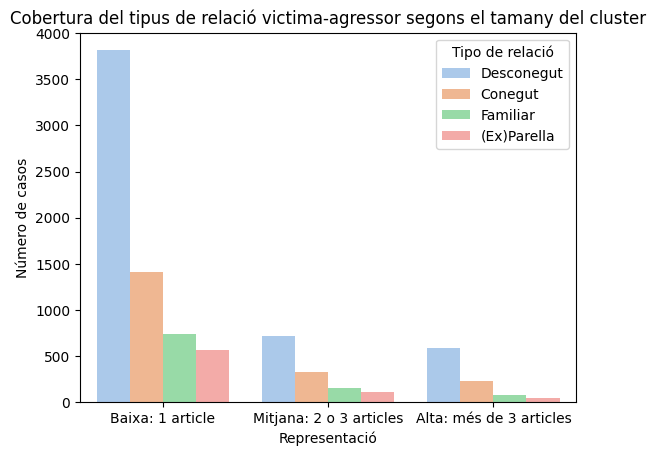

In [181]:

# Calcular el conteo de ocurrencias de cada cluster
cluster_counts_0 = cluster_ids_0.value_counts()
cluster_counts_1 = cluster_ids_1.value_counts()
cluster_counts_2 = cluster_ids_2.value_counts()
cluster_counts_3 = cluster_ids_3.value_counts()

# Contar la cantidad de clusters en cada caso
case1_0 = (cluster_counts_0 == 1).sum()
case2_0 = ((cluster_counts_0 >= 2) & (cluster_counts_0 <= 3)).sum()
case3_0 = (cluster_counts_0 >= 3).sum()

case1_1 = (cluster_counts_1 == 1).sum()
case2_1 = ((cluster_counts_1 >= 2) & (cluster_counts_1 <= 3)).sum()
case3_1 = (cluster_counts_1 >= 3).sum()

case1_2 = (cluster_counts_2 == 1).sum()
case2_2 = ((cluster_counts_2 >= 2) & (cluster_counts_2 <= 3)).sum()
case3_2 = (cluster_counts_2 >= 3).sum()

case1_3 = (cluster_counts_3 == 1).sum()
case2_3 = ((cluster_counts_3 >= 2) & (cluster_counts_3 <= 3)).sum()
case3_3 = (cluster_counts_3 >= 3).sum()


# Crear un DataFrame con los casos y sus cantidades
data = pd.DataFrame({'Opciones': ['Baixa: 1 article', 'Mitjana: 2 o 3 articles', 'Alta: més de 3 articles'],
                     'Desconegut': [case1_0, case2_0, case3_0],
                     'Conegut': [case1_3, case2_3, case3_3],
                     'Familiar': [case1_2, case2_2, case3_2],
                     '(Ex)Parella': [case1_1, case2_1, case3_1]})

# Convertir los datos a formato "largo" (long format)
data = data.melt(id_vars='Opciones',var_name='Tipo de relació', value_name='Número de casos')

# Crear el gráfico de barras con Seaborn
sns.barplot(x='Opciones', y='Número de casos',hue='Tipo de relació', data=data, palette='pastel')

# Configurar los títulos y etiquetas de los ejes
plt.title("Cobertura del tipus de relació victima-agressor segons el tamany del cluster")
plt.xlabel('Representació')
plt.ylabel('Número de casos')

# Mostrar el gráfico
plt.show()
